# Download data

In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import math

from sklearn import linear_model

In [86]:
# download and derive Russia's data

df = pd.read_csv('owid-covid-data.csv')
df = df[df.iso_code == 'RUS'].loc[:, ['date','total_cases', 'new_cases']].reset_index(drop=True)
df = df[df.date >= '2020-03-03'].reset_index(drop=True)
df.loc[:, 'new_cases'] = df.loc[:, 'new_cases'].replace(0, 1)
df['total_cases_log'] = np.log(df.loc[:, 'total_cases'])
df['new_cases_log'] = np.log(df.loc[:, 'new_cases'])

In [91]:
df.head(5)

,date,total_cases,new_cases,total_cases_log,new_cases_log
0,2020-03-03,3.0,1.0,1.098612,0.000000
1,2020-03-04,3.0,1.0,1.098612,0.000000
2,2020-03-05,4.0,1.0,1.386294,0.000000
3,2020-03-06,13.0,9.0,2.564949,2.197225
4,2020-03-07,13.0,1.0,2.564949,0.000000


In [87]:
# devide data to train and test

train_points = 50

df_train = df.iloc[:train_points, :]
df_test = df.iloc[train_points:, :]

# Plots

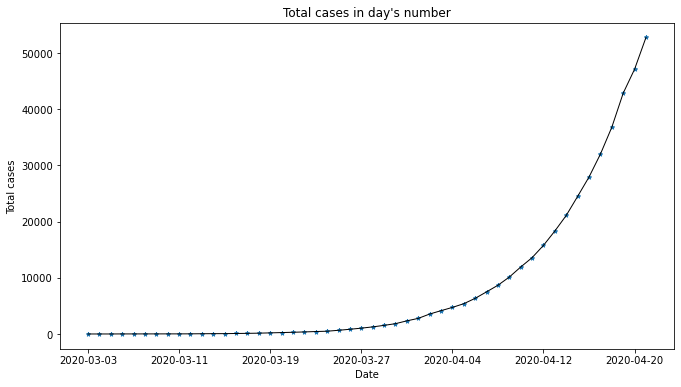

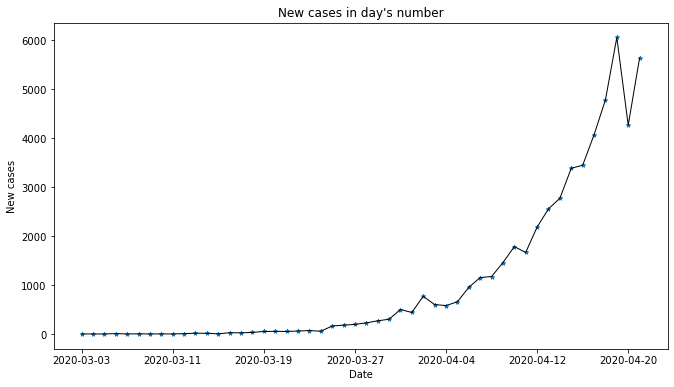

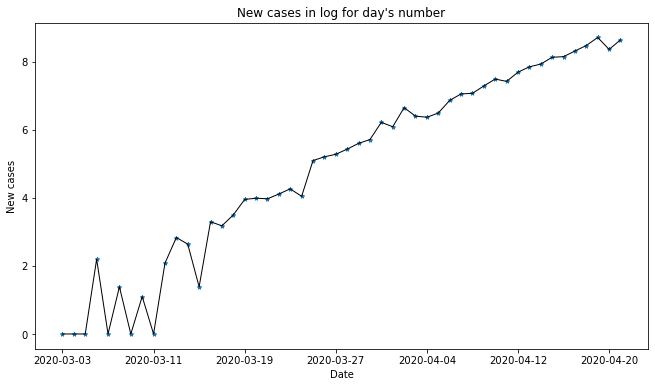

In [100]:
# plot our train data

figsize = (11,6)
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.scatter(df_train.loc[:, 'date'], df_train.loc[:, 'total_cases'], marker='*', s=16)
ax.plot(df_train.loc[:, 'date'], df_train.loc[:, 'total_cases'], linewidth=1, color="black")
ax.set_title("Total cases in day's number")
ax.set_xlabel('Date')
ax.set_ylabel('Total cases')
ax.xaxis.set_major_locator(plt.MaxNLocator(7))


fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.scatter(df_train.loc[:, 'date'], df_train.loc[:, 'new_cases'], marker='*', s=16)
ax.plot(df_train.loc[:, 'date'], df_train.loc[:, 'new_cases'], linewidth=1, color="black")
ax.set_title("New cases in day's number")
ax.set_xlabel('Date')
ax.set_ylabel('New cases')
ax.xaxis.set_major_locator(plt.MaxNLocator(7))



fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.scatter(df_train.loc[:, 'date'], df_train.loc[:, 'new_cases_log'], marker='*', s=16)
ax.plot(df_train.loc[:, 'date'], df_train.loc[:, 'new_cases_log'], linewidth=1, color="black")
ax.set_title("New cases in log for day's number")
ax.set_xlabel('Date')
ax.set_ylabel('New cases')
ax.xaxis.set_major_locator(plt.MaxNLocator(7))


# 2

### a 

$$log(y_t) = a * x_t + b + \varepsilon_t, \quad \varepsilon_t \backsim N(0, D)$$

In [132]:
def lin_reg(Y, X):
    
    L = len(X)
    
    Y = Y.to_numpy().reshape(L, 1)
    X = np.concatenate([X.reshape(L, 1), np.ones(L).reshape(L, 1)],
                       axis = 1)
    
    B = np.linalg.inv(X.T @ X) @ X.T @ Y
    E = (Y - X @B)
    D = (E.T @ E)/(L - 2)
    
    a, b =  B[:,0]
    
    return a, b, D[0][0], X.T @ X
    

In [137]:
# Linear regression
a, b, D, XTX = lin_reg(df_train.loc[:, 'new_cases_log'], np.array(range(1, train_points + 1)))

print("a_mean : {}".format(a))
print("b_mean : {}".format(b))
print("D_mean : {}".format(D))
print("XTX : {}".format(XTX))

a_mean : 0.18596309168510508
b_mean : 0.13472442721454392
D_mean : 0.37011359248035386
XTX : [[42925.  1275.]
 [ 1275.    50.]]


### b

$$ P(k, b | D, DATA) = N((a_{mean}, b_{mean}), D*(X^TX))^{-1})$$

$$ P(D|DATA) =IG(\frac{L-2}{2},\frac{L-2}{2} * D_{mean})$$

$a_{mean} = 0.18596309168510508$

$b_{mean} : 0.13472442721454392$

$D_{mean} : 0.37011359248035386$

$X^TX: [[42925,  1275],
 [ 1275,    50]]$

### c

Нам нужно генерировать параметры a, b, D. Для начала генерируем D, потом применяя posterior condition генерируем a и b. 
Но, в принципе нам достаточно будет использовать 𝐷=𝐷𝑚𝑒𝑎𝑛, так как дисперсия достаточно небольшая.

#### sample exp

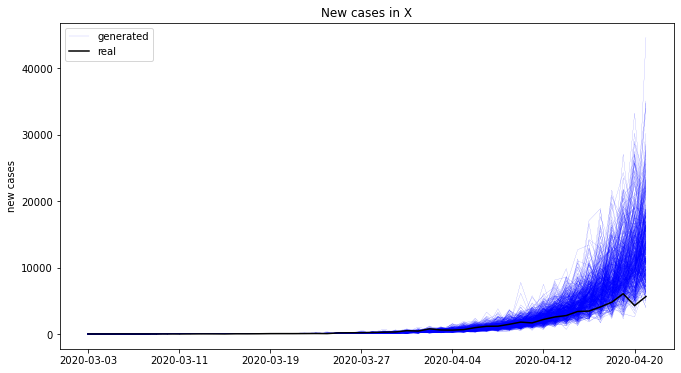

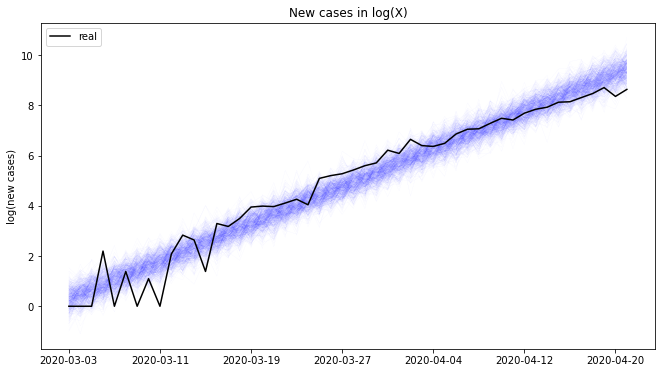

In [155]:
M = 500
mean = (a, b)
cov = np.linalg.inv(XTX) * D


figsize = (11,6)
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
y_pred = []
for i in range(M):
    
    y_list = []
    a_i, b_i = np.random.multivariate_normal(mean, cov).T
    
    for x_j in range(1, train_points + 1):
        eps_j = np.random.normal(0, D)
        y_list.append(np.exp(a_i * x_j + b_i + eps_j))
  
    y_pred.append(y_list)
    if i == M - 1: 
        plt.plot(df_train.loc[:, 'date'], y_list, color='blue', linewidth=0.1, label='generated')
    else:
        plt.plot(df_train.loc[:, 'date'], y_list, color='blue', linewidth=0.1)


plt.plot(df_train.loc[:, 'date'], df_train.loc[:, 'new_cases'].to_numpy(), color='black', label='real')
plt.ylabel('new cases')
plt.legend()
plt.plot()
plt.title("New cases in X")
ax.xaxis.set_major_locator(plt.MaxNLocator(7))
plt.show()


# plot log y from x
figsize = (11,6)
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)

for prediction in y_pred:
    plt.plot(df_train.loc[:, 'date'], np.log(prediction), color='blue', linewidth=0.01)

plt.plot(df_train.loc[:, 'date'], df_train.loc[:, 'new_cases_log'].to_numpy(), color='black', label='real')
plt.ylabel('log(new cases)')
plt.legend()
plt.plot()
plt.title("New cases in log(X)")
ax.xaxis.set_major_locator(plt.MaxNLocator(7))
plt.show()



In [156]:
def get_CI(Y, CI):
    
    def get_bound(y_list, CI):
        
        y_list.sort()
        bound_value = CI * len(y_list) 
        
        #round up
        upper_integer_upper_bound = math.ceil(bound_value)
        #round bottom
        lower_integer_upper_bound = upper_integer_upper_bound - 1

        delta = bound_value - lower_integer_upper_bound

        #take mean for values 
        y_upper_i =  (1 - delta) * y_list[lower_integer_upper_bound] + delta * y_list[upper_integer_upper_bound]
        
        return y_upper_i
    
    
    y_upper_bound = []
    y_lower_bound = []
    
    y_len = Y.shape[1]
    for i in range(y_len):
        
        #vectorization
        predictions = Y[:,i].flatten()
        predictions_mean = predictions.mean()
        
        #devided data on 2 part: higher or equal to mean value and lower mean
        predictions_upper = predictions[predictions >= predictions_mean]
        if len(predictions_upper) == 0 :
            y_upper_i = predictions_mean
        else:    
            y_upper_i = get_bound(predictions_upper, CI)
        
        y_upper_bound += [y_upper_i]
        
        predictions_lower = predictions[predictions < predictions_mean]
        if len(predictions_lower) == 0 :
            y_upper_i = predictions_mean
        else:    
            y_upper_i = - get_bound(predictions_lower * (-1), CI)
        
        y_lower_bound += [y_upper_i]
        
    return [y_upper_bound, y_lower_bound]

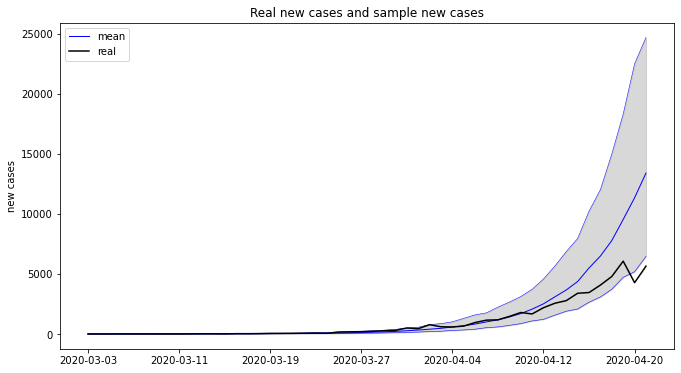

In [164]:
y_pred_arr = np.array(y_pred)

# get CI bound
upper_bound, lower_bound = get_CI(y_pred_arr, 0.9) # CI in between 0.05 to 0.95

figsize = (11,6)
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)

# CI
plt.plot(df_train.loc[:, 'date'], upper_bound, color='blue', linewidth=0.5)
plt.plot(df_train.loc[:, 'date'], lower_bound, color='blue', linewidth=0.5)
plt.plot(df_train.loc[:, 'date'], y_pred_arr.mean(axis=0), color='blue', linewidth=1, label='mean')
plt.fill_between(df_train.loc[:, 'date'], upper_bound, lower_bound, color = "gray", alpha = 0.3)

# real data
plt.plot(df_train.loc[:, 'date'], df_train.loc[:, 'new_cases'], color='black', label='real')
plt.ylabel('new cases')
plt.legend()
plt.plot()
plt.title("Real new cases and sample new cases")
ax.xaxis.set_major_locator(plt.MaxNLocator(7))
plt.show()

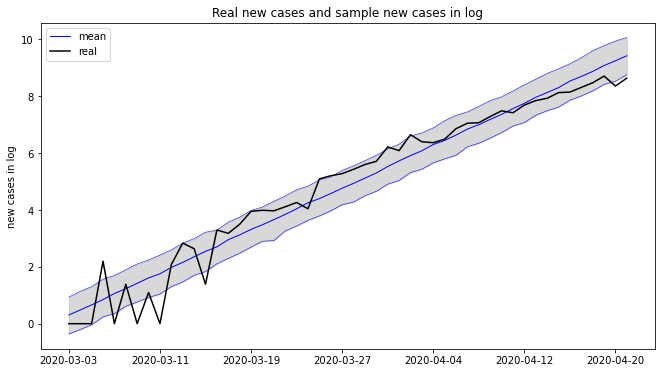

In [167]:
y_pred_arr = np.log(np.array(y_pred))

# get CI bound
upper_bound, lower_bound = get_CI(y_pred_arr, 0.9) # CI in between 0.05 to 0.95

figsize = (11,6)
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)

# CI
plt.plot(df_train.loc[:, 'date'], upper_bound, color='blue', linewidth=0.5)
plt.plot(df_train.loc[:, 'date'], lower_bound, color='blue', linewidth=0.5)
plt.plot(df_train.loc[:, 'date'], y_pred_arr.mean(axis=0), color='blue', linewidth=1, label='mean')
plt.fill_between(df_train.loc[:, 'date'], upper_bound, lower_bound, color = "gray", alpha = 0.3)

# real data
plt.plot(df_train.loc[:, 'date'], df_train.loc[:, 'new_cases_log'], color='black', label='real')
plt.ylabel('new cases in log')
plt.legend()
plt.plot()
plt.title("Real new cases and sample new cases in log")
ax.xaxis.set_major_locator(plt.MaxNLocator(7))
plt.show()

### Prediction destribution

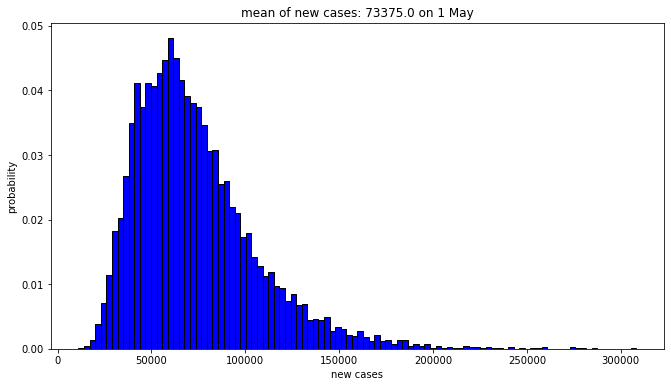

In [176]:
Prediction_point = df[df.date == '2020-05-01'].index[0] # 1 May
M = 10000
pred = []
for i in range(M):
    a_i, b_i = np.random.multivariate_normal(mean, cov).T
    eps_j = np.random.normal(0, D)
    pred.append(np.exp(a_i * Prediction_point + b_i + eps_j))


# histogram
figsize = (11,6)
fig = plt.figure(figsize=figsize)

plt.hist(pred, 
         color = 'blue', 
         edgecolor = 'black',
         bins = 100, 
         weights = [1/len(pred)] * len(pred))
plt.plot()


# Add labels
plt.title('mean of new cases: {} on 1 May'.format(np.round(np.mean(pred))))
plt.ylabel('probability')
plt.xlabel('new cases')
plt.show()

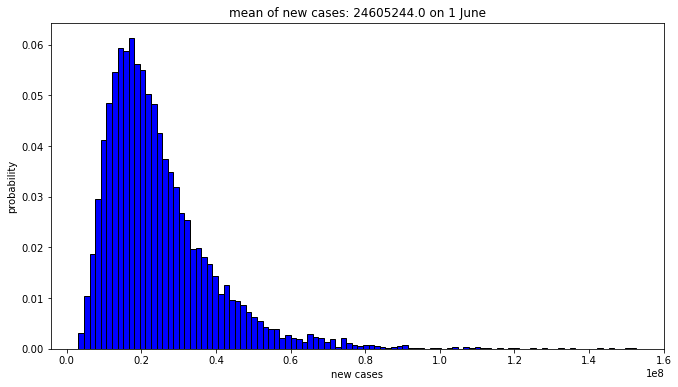

In [178]:
Prediction_point = df[df.date == '2020-06-01'].index[0] # 1 June
M = 10000
pred = []
for i in range(M):
    a_i, b_i = np.random.multivariate_normal(mean, cov).T
    eps_j = np.random.normal(0, D)
    pred.append(np.exp(a_i * Prediction_point + b_i + eps_j))


# histogram
figsize = (11,6)
fig = plt.figure(figsize=figsize)

plt.hist(pred, 
         color = 'blue', 
         edgecolor = 'black',
         bins = 100, 
         weights = [1/len(pred)] * len(pred))
plt.plot()


# Add labels
plt.title('mean of new cases: {} on 1 June'.format(np.round(np.mean(pred))))
plt.ylabel('probability')
plt.xlabel('new cases')
plt.show()

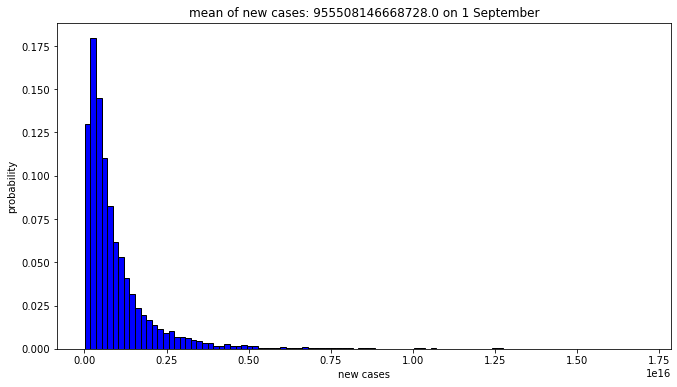

In [179]:
Prediction_point = df[df.date == '2020-09-01'].index[0] # 1 September
M = 10000
pred = []
for i in range(M):
    a_i, b_i = np.random.multivariate_normal(mean, cov).T
    eps_j = np.random.normal(0, D)
    pred.append(np.exp(a_i * Prediction_point + b_i + eps_j))


# histogram
figsize = (11,6)
fig = plt.figure(figsize=figsize)

plt.hist(pred, 
         color = 'blue', 
         edgecolor = 'black',
         bins = 100, 
         weights = [1/len(pred)] * len(pred))
plt.plot()


# Add labels
plt.title('mean of new cases: {} on 1 September'.format(np.round(np.mean(pred))))
plt.ylabel('probability')
plt.xlabel('new cases')
plt.show()

As we can see from our exponential model the results of prediction are not correct. Exponential model does not appropriate for forecasting desease spread